# **Chicago Crime Analysis**

**Author:** Meg Hutch

**Date:** June 10, 2020

**Data source:** Data was accessed from [data.cityofchicago](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2). 

As described on their website:
> "This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system."

In this analysis several machine and deep learning methods are implemented to examine the utility of these advanced analytic methods in predicting crime in the city of Chicago which occured in from January-May of 2020.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [2]:
crime_df = pd.read_csv(r'C:\\Users\\User\\Box Sync/Projects/Chicago_Crimes/Crimes_-_2001_to_present.csv')

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# **Methods**

### **Data Pre-Processing**

Several pre-processing steps were required to work with the data. 

The dataset was modified as follows:

1. Filter for cimes occuring in 2020
2. Remove white space from column names
3. Concatenate Primary_Type and Description
4. Convert Community_Area to type 'object'
5. Remove Primary_Type categories that occured < 1000 times
6. Remove missing values

In [3]:
# Step 1
crime_df = crime_df[crime_df['Year'] == 2020]

# Step 2
crime_df.columns = crime_df.columns.str.replace(' ', '_')

# Step 3
crime_df["Primary_Type_Description"] = crime_df["Primary_Type"] + " " +  crime_df["Description"]

# Step 4
crime_df['Community_Area'] = crime_df['Community_Area'].astype(object)

# Step 5
crime_df['freq'] = crime_df.groupby('Primary_Type')['Primary_Type'].transform('count')
crime_df = crime_df[crime_df.groupby('Primary_Type').freq.transform(len) > 1000]

# Step 6
crime_df = crime_df.dropna()

After our initial pre-processing step, we see that there are 75,628 crimes and 12 unique crimes that occured from January-June 2020

In [4]:
print('Number of Observations:', crime_df.shape)
unique, counts = np.unique(crime_df.Primary_Type, return_counts = True)
print('Number of Unique Crimes:',  len(unique))

Number of Observations: (75628, 24)
Number of Unique Crimes: 12


### **Model Preparation**

From exporing the data, many columns appear to be collinear to one another, and thus, inlcuding all predictors would be redundant and may not provide any extra information, just increase our computational time! For example, IURC (Illinois Unifrom Crime Reporting code) is said to be "Directly linked to the Primary Type and Description". 

Additionally, FBI Code is a variable that describes the type of crime. Because our aim is to predict the type of crime (Primary_Type), it is also important to remove any variables that may leak information about our primary outcome. 

The following steps were performed in order to further process the data for modeling:

1. Select columns of interest - **Primary_Type**, **Arrest**, **Domestic**, **Location_Description**, and **Community_Area**. 
2. Divide dataset into inputs (crime_x) and output variable (crime_y)
3. One-hot encode categorical inputs in crime_x 
4. Recode crime_y to convert data from categorical labels to numeric 
5. Convert dataframes to arrays and reshape crime_y
6.Shuffle & Split data into training and testing sets using a 75/25% split. Additionally, our primary outcome variable, Primary_Type, is stratified to ensure that each class of our outcome is proportionally represented in each dataset. 



In [6]:
# Step 1
crime_model = crime_df[['Primary_Type', 'Location_Description', 'Arrest', 'Domestic', 'Community_Area']]

# Step 2
crime_x = crime_model[['Location_Description', 'Arrest', 'Domestic', 'Community_Area']]
crime_y = crime_model[['Primary_Type']]

# Step 3
crime_x.loc[:, 'Arrest'] = pd.factorize(crime_x['Arrest'])[0].reshape(-1,1)
crime_x.loc[:, 'Domestic'] = pd.factorize(crime_x['Domestic'])[0].reshape(-1,1)
crime_x = pd.get_dummies(crime_x)
crime_x_col_names = list(crime_x.columns.values) 

# Step 4
crime_y.loc[:, 'Primary_Type_Code'] = pd.factorize(crime_y['Primary_Type'])[0].reshape(-1,1)
crime_list = crime_y[['Primary_Type', 'Primary_Type_Code']].drop_duplicates()
crime_y = crime_y[['Primary_Type_Code']]

# Step 5
crime_x = np.array(crime_x)
crime_y = np.array(crime_y)

crime_y = crime_y.reshape(-1)

# Step 6
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss.get_n_splits(crime_x, crime_y)

for train_index, test_index in sss.split(crime_x, crime_y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = crime_x[train_index], crime_x[test_index]
    y_train, y_test = crime_y[train_index], crime_y[test_index]

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


TRAIN: [69714  7928 48593 ... 31234 18461 16908] TEST: [20038 13366  1725 ... 29207 10927 13728]


## **Functions for Models**

Functions adapated from: [github.com/geickelb](https://github.com/geickelb/HSIP442_guest_lecture/blob/master/notebooks/modeling.ipynb)

### **Logistic Regression**

**ROC Curve**

This function will print an ROC Curve.

In [8]:
# View ROC Curve
def ez_roc(model, x, y, pos_label=1):
    """prints a basic Recievor Operator Curve (ROC). 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    pos_label --binary label considered positive in y  (dtype='int', default=1)
    """
    from sklearn.metrics import roc_curve, auc

    model_name=type(model).__name__ # defining model name as the __name__ characteristic held by sklearn models

    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC curve')
    ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return()

**Evaluate Model**

This function includes parameters for cross-fold validation. Additionally, as we are working with a multi-classification problem, we evaluate our logistic regression models with one-vs-one classification.

In [9]:
def evaluate_model(model, x, y, cv = True):
    """prints common binary classification evaluation metrics and an ROC curve. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints  score from 5-fold crossvalidation (dtype='boolean', default='True')
    """
    import sklearn.metrics
    from sklearn.metrics import log_loss, average_precision_score, precision_recall_curve
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import StratifiedKFold

    if cv==True:
        cv_results= cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=StratifiedKFold(5))
        print("across 5 fold cv on trainingset, the model had \n", 
             "mean auroc: {:0.3f}".format(np.mean(cv_results)), "\n",
             "std auroc: {:0.3f}".format(np.std(cv_results))
             )

        base_cv_score=np.mean(cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=StratifiedKFold(5)))

    print("###metrics on provided dataset:###")
    
    ##basic model performance
    y_hat = model.predict(x) # predicted classes using default 0.5 threshold
    y_proba = model.predict_proba(x)[:,] #predicted probabilities
    auc=roc_auc_score(y, y_proba, multi_class = 'ovr', average = 'weighted')

    print ('the AUC is: {:0.3f}'.format(auc))
    
    # Modify labels for the classification reports
    crime_labels = list(range(0,11))
    crime_labels = np.asarray(crime_labels)
    
    crime_names = crime_list.Primary_Type.tolist()
    
    print("classification report:\n ", classification_report(y, y_hat, labels = crime_labels, target_names = crime_names, digits=3))

    #ez_roc(model, x, y, pos_label = 1) #plotting roc curve
    #plt.show()

### **Random Forest**

This function includes parameters for stratified cross-fold validation and supports code for hyperparameter tuning for a random forest model. Because we are working with a multi-classification problem, we evaluate our logistic regression models with one-vs-one classification.

In [10]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, scoring = 'roc_auc_ovo_weighted', verbose=True, cv = True, 
                    return_train_score = True): 
    """function that uses GridSearchCV to test a specified param_grid of hyperparameters and choose the optimal one based on nfolds cross-validation results. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    X -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints a the roc_auc score from 10-fold crossvalidation (dtype='boolean', default='True')
    """
    
    np.random.seed(12345)
    
    # The scorers can be either be one of the predefined metric strings or a scorer
    # callable, like the one returned by make_scorer
    #scoring = {'AUC': 'roc_auc_ovr', 'Accuracy': make_scorer(accuracy_score)}

    grid_search = GridSearchCV(estimator= model,
                                     param_grid=param_grid,
                                     cv=StratifiedKFold(nfolds), # stratified k-folds will preserve class balances - this function is what got the rest of the code to work with roc validation
                                     scoring=scoring,
                                     return_train_score=True,
                                     n_jobs = -1)
    
    #scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc_ovr'}
    #scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

    grid_search.fit(X, y)
    print(" scorer function: {}".format(scoring))
    print(" ##### CV performance: mean & sd scores #####")

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    print('best cv score: {:0.3f}'.format(grid_search.best_score_))
    print('best cv params: ', grid_search.best_params_)

    worst_index=np.argmin(grid_search.cv_results_['mean_test_score'])
    print('worst cv score: {:0.3f}'.format(grid_search.cv_results_['mean_test_score'][worst_index]))
    print('worst cv params: ', grid_search.cv_results_['params'][worst_index])
    ##
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    
    return(grid_search)
    #print(grid_search.cv_results_)

# **Analyses & Results**

### **Descriptives**

**Top 10 Crimes**

The top 10 crimes include: 

1. Theft
2. Battery
3. Criminal Damage
4. Assault
5. Other Offense
6. Deceptive Practice
7. Narcotics
8. Motor Vehicle Theft
9. Burgalry 
10. Robbery

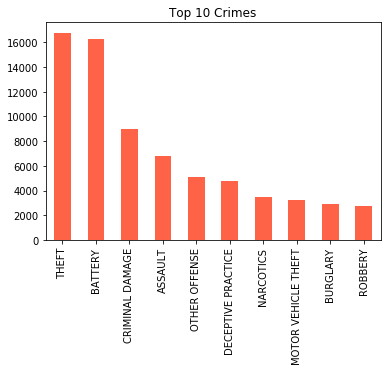

In [147]:
crime_df10 = crime_model.Primary_Type.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Crimes")
plt1.get_legend().remove()

**Top 10 Crime Locations**

The top 10 locations where crimes were committed include: 

1. Steet
2. Apartment
3. Residence
4. Sidewalk 
5. Small Retail Store
6. Restaurant
7. Alley 
8. Other
9. Gas Station
10. Grocery Food Store

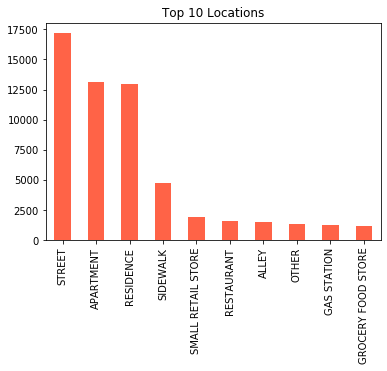

In [149]:
crime_df10 = crime_model.Location_Description.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Locations")
plt1.get_legend().remove()

**Top 10 Communities**

The top 10 communities with the highest numebr of crimes include:

1. West Garfield Park
2. Unknown
3. Unknwon
4. North Lawndale
5. Near West Side
6. Humboldt Park
7. Auburn Gresham
8. Greater Grand Crossing
9. Loop
10. Roseland

**Community_Area numbers were cross referenced from the area codes and communities accessible [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6).*

***A few Area_Codes were missing and were thus listed as "Unknown"*

Text(0.5, 1.0, 'Top 10 Communities')

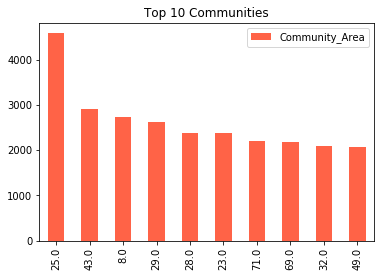

In [13]:
crime_df10 = crime_model.Community_Area.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Communities")

**Domestic**

The number of Domestic (True) vs Non-Domestic (False) crimes

Text(0.5, 1.0, 'Top 10 Communities')

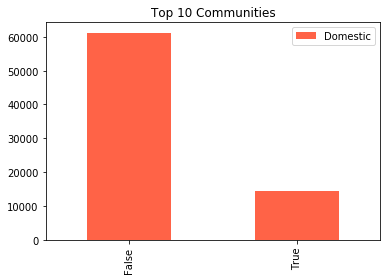

In [14]:
crime_df10 = crime_model.Domestic.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Communities")

**Crimes resulted in Arrest**

The number of crimes resulting in Arrest (True) vs Non-Arrest (False)

Text(0.5, 1.0, 'Top 10 Communities')

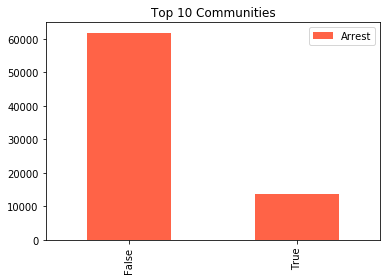

In [150]:
crime_df10 = crime_model.Arrest.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Communities")

## **Logistic Regression**

Our first classification method was performed with logistic regression. Logistic regression models are able to make predictions through the logistic function and which faciliatates prediction of binary outputs. However, multi-classification techniques, as will be described in more detail, enable us to apply logistic regression classifiers on datasets with multiple classes. 

In this analysis logistic regression was performed with an l2 penalty in order to include a regularization method which works to prevent overfitting by decreasing the weights of the features to a small number (though a number that is still higher than zero). Additionally, we used specified the solver parameters as 'sag' (Stochastic Average Gradient descent), which can work with l2 penalities and which is said to minimize the cost function more quickly for large datasets [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Predictions were made using One vs One (OVO), a multi-classification method which creates indiviudal classifiers to compare each pair-wise class. Each classifier then votes when making a prediction on a new test sample; the class with the most votes becomes our final predicted class [source](https://datastoriesweb.wordpress.com/2017/06/11/classification-one-vs-rest-and-one-vs-one/).

In order to evaluate a model more rigourously, the training data was evaluated through our logistic regression classifier and 5-cross fold validation was performed. Our average AUC across each of the 5 training folds was 0.797, while our model had an AUC of 0.787 on the testing data. 

We further examine the classification report from our testing data which includes the precision, recall, f1-score, and support (# of samples), for each outcome. **Recall** details the sensitivity of our models, in other words, the true positive rate. **Precision** is the numebr of true positives/total number of true positives + true false positives. The **f1-score** provides a balance between precision and recall and is caluated as 2 X (Presicion*Recall/Precision+Recall)

Interestingly, though it had few samples than other outcomes (support = 871), the prediction of Narcotic crimes had the highest recall at 0.761. It's precision and f1-score were 0.579 and 0.467, respectively.

Theft had the second highest recall (0.706) with a precision of 0.401 and f1-score of 0.512. Important to note, the incidence of Theft had the most samples in our testing data (support = 4194), which likely made it easier for the model to learn the input features associated with Theft. 

Battery also had the third highest recall (0.657) and a higher precision than Theft and Narcotics (0.509). Battery had the second highest number of observations (support = 4062). 

Other Offense, Assault, Robbery and Motor Vehuicle Theft all had recalls < 0.10 and precision ranged from 0.075 - 0.252. It seems predictable that Other Offense may have both the lowest precision, recall, and f1-score metrics due to being a vague descriptor. 

### **Evaluation of Training Data**

In [16]:
# reshape data
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [17]:
t1 = time.time()

lr = LogisticRegression(penalty='l2', solver='sag', random_state = 12345)
#fit model
lr.fit(X_train, y_train)
#evaluate model (on training data)
evaluate_model(lr, X_train, y_train, cv = True)

t2 = time.time()

run_time = t1 - t2
print('Training Time in Minutes:', run_time/60)

across 5 fold cv on trainingset, the model had 
 mean auroc: 0.797 
 std auroc: 0.001
###metrics on provided dataset:###
the AUC is: 0.791


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1989: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))


classification report:
                       precision    recall  f1-score   support

              THEFT      0.399     0.708     0.510     12584
      OTHER OFFENSE      0.097     0.006     0.012      3847
            ASSAULT      0.313     0.010     0.019      5095
            BATTERY      0.512     0.657     0.575     12186
           BURGLARY      0.361     0.165     0.226      2165
 DECEPTIVE PRACTICE      0.320     0.402     0.357      3601
    CRIMINAL DAMAGE      0.238     0.194     0.213      6718
          NARCOTICS      0.493     0.795     0.608      2621
  WEAPONS VIOLATION      0.336     0.178     0.233      1934
            ROBBERY      0.319     0.117     0.171      2071
MOTOR VEHICLE THEFT      0.259     0.068     0.107      2425

          micro avg      0.409     0.415     0.412     55247
          macro avg      0.332     0.300     0.276     55247
       weighted avg      0.362     0.415     0.352     55247

Training Time in Minutes: -6.543017141024271


### **Evaluation of Testing Data**

In [18]:
evaluate_model(lr, X_test, y_test, cv = False)

###metrics on provided dataset:###
the AUC is: 0.787
classification report:
                       precision    recall  f1-score   support

              THEFT      0.401     0.706     0.512      4194
      OTHER OFFENSE      0.075     0.006     0.012      1282
            ASSAULT      0.185     0.006     0.011      1699
            BATTERY      0.509     0.660     0.574      4062
           BURGLARY      0.331     0.130     0.187       721
 DECEPTIVE PRACTICE      0.308     0.394     0.346      1201
    CRIMINAL DAMAGE      0.210     0.169     0.187      2239
          NARCOTICS      0.467     0.761     0.579       874
  WEAPONS VIOLATION      0.298     0.161     0.209       645
            ROBBERY      0.252     0.091     0.134       690
MOTOR VEHICLE THEFT      0.226     0.062     0.097       809

          micro avg      0.401     0.406     0.404     18416
          macro avg      0.297     0.286     0.259     18416
       weighted avg      0.337     0.406     0.342     18416



C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1989: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))


## **Random Forest**

In the article [*Do we Need Hundreds of Classifiers to Solve Real World
Classification Problems?*](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf), the authors tested over 171 different classifiers and noted that Random Forests tend to be the strongest type of classifier among a diversity of different datasets. 

To expound, Random Forests are an ensemble type classifier. Unlike normal decision trees which start with the root node and continuously split as they make decisions, Random Forests decisions are made by constructing hundreds to thousands of individual trees. Each indiviudal tree only use a subset of all the features, and individual trees are considered uncorrelated. Final predictions are made by choosing the majority vote from all these indiviudal classifiers. Yiu, T, really digs into the power of using random forests [source](https://towardsdatascience.com/understanding-random-forest-58381e0602d2). By using so many indiviudal voters, indiviudals errors are masked by the overall majority vote in the end. Lastly, a benefit of using Random Forests, are that we can aquire a feature importance plot that explicitly show us which variables most infleunced model performance. 



#### **Methods of implementing our Random Forest model include:**

1. First, we specify a parameter grid where we explore models by changing a number of parameters including:  max_depth, min_samples_split, and min_samples_leaf

2. We then instatiate a RandomForestClassifier with criterion 'entropy'

3. We explore the set hyperparameters and perform 5 cross-fold valdiation on our crime data. Once again we assess classification performing using the one-vs-one multi-classification method. 

#### **Results**

Our hyperparameter searching identified that the best performing model had a cross-validation score of 0.789 and parameters set as follows:

```max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100```

On our testing set, our best performing random forest model had an AUC of 0.788. The crime with the highest recall in our random forest model was Theft (0.924), with a precision of 0.308. Narcotics had the second highest recall (0.793, precision = 0.474), followed by Battery (0.620). Interestingly, while Deceptive Practice only had a recall of 0.055, it had the highest precision (0.717). Also noteworthy to point out, the rest of the crimes in our model had poor predictive values with recall and precisions of 0, conveying that our random forest models were not robust enough to delineate the relationships between our inputs and those crimes.

In our feature importance plot, we see that the top 5 features included:

1. Arrest
2. Domestic
3. Location - Street
4. Location - Residence
5. Location - Sidewalk

Important to note, in the plot detailing the top 15 important features, we don't see any specific communities detailed until features 13-15. Community_Area 32 and 26 indicate the Loop and West Garfield Park, respectively. 

**(Community_Area=8 was unknown as described above)*

**Reshape y data**

In [19]:
y_train = y_train.ravel()
y_test = y_test.ravel()

### **Set Hyperparameters and Run Models**

In [20]:
# Number of trees in random forest
n_estimators = [100]
# Number of features to consider at every split
max_features = ['auto'] # 'auto' which is equivalent to sqrt(n_features)
# Maximum number of levels in tree
max_depth = [5, 10]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

t1 = time.time()

model = RandomForestClassifier(criterion='entropy', random_state=12345)
rf_hyper = hypertuning_fxn(X_train, y_train, nfolds = 5, model = model , param_grid = param_grid, scoring = 'roc_auc_ovo_weighted', cv = True, return_train_score = True)

t2 = time.time()

run_time = t1 - t2
print('Training Time in Minutes:', run_time/60)

 scorer function: roc_auc_ovo_weighted
 ##### CV performance: mean & sd scores #####
best cv score: 0.789
best cv params:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
worst cv score: 0.782
worst cv params:  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.782 (+/-0.002) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.782 (+/-0.002) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.782 (+/-0.002) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.782 (+/-0.003) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.782 (+/-0.003) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples

### **Return the Best Estimator**

In [21]:
print(rf_hyper.best_estimator_)
rf = rf_hyper.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


## **Evaluation of Training Data**

In [22]:
t1 = time.time()

evaluate_model(rf_hyper.best_estimator_, X_train, y_train, cv=False)

t2 = time.time()

run_time = t1 - t2
print('Training Time in Minutes:', run_time/60)

###metrics on provided dataset:###
the AUC is: 0.788
classification report:
                       precision    recall  f1-score   support

              THEFT      0.307     0.925     0.461     12584
      OTHER OFFENSE      0.000     0.000     0.000      3847
            ASSAULT      0.000     0.000     0.000      5095
            BATTERY      0.531     0.615     0.570     12186
           BURGLARY      0.000     0.000     0.000      2165
 DECEPTIVE PRACTICE      0.734     0.048     0.091      3601
    CRIMINAL DAMAGE      0.000     0.000     0.000      6718
          NARCOTICS      0.481     0.821     0.606      2621
  WEAPONS VIOLATION      0.000     0.000     0.000      1934
            ROBBERY      0.000     0.000     0.000      2071
MOTOR VEHICLE THEFT      0.000     0.000     0.000      2425

          micro avg      0.378     0.388     0.383     55247
          macro avg      0.187     0.219     0.157     55247
       weighted avg      0.258     0.388     0.265     55247

Trai

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1989: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Evaluation of Testing Data**

In [23]:
evaluate_model(rf_hyper.best_estimator_, X_test, y_test, cv = False)

###metrics on provided dataset:###
the AUC is: 0.780
classification report:
                       precision    recall  f1-score   support

              THEFT      0.308     0.924     0.462      4194
      OTHER OFFENSE      0.000     0.000     0.000      1282
            ASSAULT      0.000     0.000     0.000      1699
            BATTERY      0.526     0.620     0.569      4062
           BURGLARY      0.000     0.000     0.000       721
 DECEPTIVE PRACTICE      0.717     0.055     0.102      1201
    CRIMINAL DAMAGE      0.000     0.000     0.000      2239
          NARCOTICS      0.474     0.793     0.593       874
  WEAPONS VIOLATION      0.000     0.000     0.000       645
            ROBBERY      0.000     0.000     0.000       690
MOTOR VEHICLE THEFT      0.000     0.000     0.000       809

          micro avg      0.378     0.388     0.383     18416
          macro avg      0.184     0.217     0.157     18416
       weighted avg      0.255     0.388     0.266     18416



C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1989: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Feature Importance**

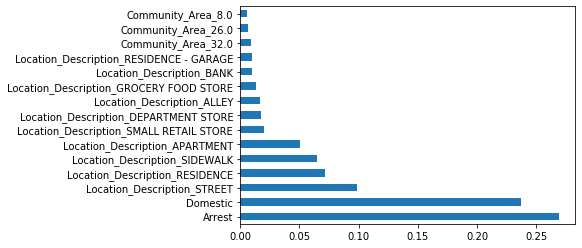

In [152]:
# create empty list
feat_impts = [] 
# bind all rf estimators for each classifier 
for clf in rf_hyper.best_estimator_:
    feat_impts.append(clf.feature_importances_)

# calculate the mean of features across predictors
feat = np.mean(feat_impts, axis=0)
# create a list of features (predictor names)
features = crime_x_col_names
# add predictor names to the means
feat_importances = pd.Series(feat, index = features)   

# plot feature importance for nlargest means 
feat_importances.nlargest(15).plot(kind='barh')

# Deep Learning

Deep learning is a powerful application for modeling non-linear functions. In such a large dataset as we have here, it is hoped that a neural network may provide us with a more robust classifier.

Our model includes 2 hidden layers with 100 and 50 nodes respectively. 

Other hyperparameters were set as follows: 

1. Batch size = 32
2. Learning rate = 0.01
3. Optimizer = stochastic gradient descent
4. Loss function = Cross Entropy Loss
5. Number of Epochs = 100

#### **Results**

Our preliminary neural networks only had a classification accuracy of 40.6% and thus, at the surface, does not prove to be an adequate classifier for crime. However, we have not performed an exhuastive search and evaluation on all hyperparameters. Nor have we investigated which crimes the model may be correclty classifying, and those in which it is having the most trouble classifying. 

### **Data Pre-processing for Neural Network**

In [160]:
# Create a tensor from Numpy array
xb = torch.from_numpy(X_train).float()
yb = torch.from_numpy(y_train).float()
trainloader = TensorDataset(xb, yb)

### **Define Neural Network Architecture**

In [161]:
nn_model = nn.Sequential(nn.Linear(213, 100),
                          nn.ReLU(),
                          nn.Linear(100, 50), 
                          nn.ReLU(), 
                          nn.Linear(50, 12))

### **Set Neural Network Hyperparameters**

In [162]:
batch_size = 32
learning_rate = 0.01
optimizer = optim.SGD(nn_model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()
n_epochs = 100
trainloader = torch.utils.data.DataLoader(trainloader, batch_size, shuffle = True)

### **Evaluation of Training Data**

In [163]:
t1 = time.time()

# store running loss
total_step = len(trainloader)
loss_list = []
acc_list = []
running_loss_res = []

for e in range(n_epochs):
    # Define running loss as 0
    running_loss = 0

    # Run the model for each xb, yb in the trainloader.  
    for i, (xb, yb) in enumerate(trainloader):
        # clear gradients - otherwise they are stored
        optimizer.zero_grad()
        # Training pass
        output = nn_model.forward(xb)
        # caluclate loss calculated from the model output compared to the labels
        loss = criterion(output, yb.long()) 
        # backpropagate the loss
        loss.backward()
        # step function to update the weights
        optimizer.step()
        # record losses
        loss_list.append(loss.item()) 
        
        # Track the accuracy
        total = yb.size(0)
        _, predicted = torch.max(output.data, 1)
        correct = (predicted == yb).sum().item()
        acc_list.append((correct /total)*100)

        running_loss += loss.item() # loss.item() gets the scalar value held in the loss. 
        # += function: Adds the running_loss (0) with loss.item and assigns back to running_loss
    else:
        print("Epoch {}/{}, Training loss: {:.5f}".format(e+1, n_epochs, running_loss/len(trainloader)))
        
        # append all running_losses
        running_loss_res.append(running_loss/len(trainloader))
        
        
t2 = time.time()
run_time = t1-t2

train_loss = np.mean(running_loss_res)
train_accuracy = np.mean(acc_list)

print('Train Loss (mean)', train_loss)
print('Train Accuracy', train_accuracy)
print('Training time in minutes:', run_time/60)

Epoch 1/100, Training loss: 2.26252
Epoch 2/100, Training loss: 2.12788
Epoch 3/100, Training loss: 2.02038
Epoch 4/100, Training loss: 1.92627
Epoch 5/100, Training loss: 1.86826
Epoch 6/100, Training loss: 1.83151
Epoch 7/100, Training loss: 1.80901
Epoch 8/100, Training loss: 1.79307
Epoch 9/100, Training loss: 1.78011
Epoch 10/100, Training loss: 1.76880
Epoch 11/100, Training loss: 1.75910
Epoch 12/100, Training loss: 1.75123
Epoch 13/100, Training loss: 1.74459
Epoch 14/100, Training loss: 1.73855
Epoch 15/100, Training loss: 1.73414
Epoch 16/100, Training loss: 1.72967
Epoch 17/100, Training loss: 1.72611
Epoch 18/100, Training loss: 1.72263
Epoch 19/100, Training loss: 1.71951
Epoch 20/100, Training loss: 1.71649
Epoch 21/100, Training loss: 1.71314
Epoch 22/100, Training loss: 1.71067
Epoch 23/100, Training loss: 1.70759
Epoch 24/100, Training loss: 1.70482
Epoch 25/100, Training loss: 1.70242
Epoch 26/100, Training loss: 1.70021
Epoch 27/100, Training loss: 1.69817
Epoch 28/1

### **Plot Training Loss and Accuracy Over Time**

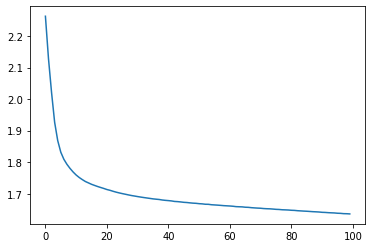

In [166]:
%matplotlib inline

test = list(range(100)) # number of epochs
plt.plot(test, running_loss_res)

### **Evaluate the Testing Data**

In [165]:
# Convert arrays into tensors
xb = torch.from_numpy(X_test).float()
yb = torch.from_numpy(y_test).float()

# Apply the model to the testing dataset
# Thus will enable us to see the predictions for each class
ps = nn_model(xb)

# Obtain the top prediction
top_p, top_class = ps.topk(1, dim=1)

# Drop the grad by using detach
top_p = top_p.detach().numpy()
top_class = top_class.detach().numpy()

yb = yb.reshape(-1,1)

# convert to integers
top_class = top_class.astype(np.int)

# convert to dataframe
top_class = pd.DataFrame(top_class)
yb = np.asarray(yb)
yb = pd.DataFrame(yb)

# change column names
top_class.columns = ["Predicted"]
yb.columns = ["True Label"]

results = pd.merge(top_class, yb, left_index=True, right_index=True)

results['Accurate'] = np.where(results['Predicted']==results['True Label'], 1, 0)

print('Testing Accuracy:', sum(results.Accurate)/len(results)*100)

Testing Accuracy: 40.60400909715978


# K-Nearest-Neighbors

A K-Nearest Neighbors (KNN) algorithm was applied to our training data in order to see whether the closest predicted nieghbor (k = 1) of each sample in the test set, would have the same crime as its chosen neighbor from the training set. 

Unfortunately, of the roughly 18,000 test samples, only ~28% of the chosen neighbors had the same crime. Thus, KNN may not be the appropriate choice for predicting crime. There are likely too many variations in our inputs to accurately predict crime just based on nearest neighbor alone. 

To elucidate which crimes the KNN model was more successfully at choosing neighbors for, we can see that Theft, Other Offense, Assualt, and Battery were the top 4 crimes types beloning to neighbors between the test and training sets who had the same crime type. It is interesting that Other Offense was ranked so highly as our other classifiers had trouble classifying this seemingly elusive crime type. Furthermore, in contrast to our logistic and Random Forest models, not many matching neighbors had committed Narcotic associated crimes. 

In [164]:
t1 = time.time()

# two neighbors will bring the point itself, and then its next nearest neighbor
neighbors = NearestNeighbors(n_neighbors = 1, algorithm='ball_tree').fit(X_train)
distances, indices = neighbors.kneighbors(X_test)

#print(distances)
#print(indices)

t2 = time.time()
run_time = t1-t2
print('Training time in minutes:', run_time/60)

Training time in minutes: -5.845267005761465


**Merge the committed crime for the index row and its nearest neighbor**

In [145]:
neighbor_crime_list = []

indices = pd.DataFrame(indices)
indices.columns = ['n1']

y_test_df = pd.DataFrame(y_test)
y_test_df.columns = ['crime_test']

test = pd.merge(indices, y_test_df, left_index=True, right_index=True)

y_train_df = pd.DataFrame(y_train)
y_train_df.columns = ['crime_train']
y_train_df['n1'] = y_train_df.index

test = pd.merge(test, y_train_df, on = 'n1')

**Calculate the proportion of neighbors who had the same crime**

In [146]:
test['crime_match'] = test['crime_train'] - test['crime_test']
print('Accuracy:', test.crime_match[test.crime_match==0].count()/len(test)*100)

Accuracy: 27.920875866081346


**Type of Crime belong to chosen neighbors with the same Crime**

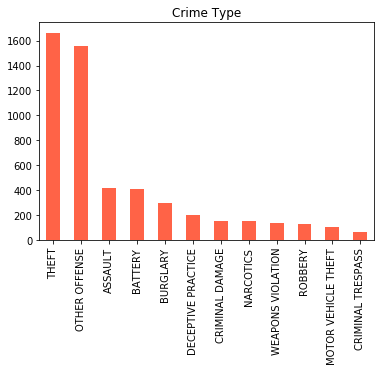

In [144]:
matched = test[test['crime_match'] == 0]

crime_df10 = matched.crime_test.value_counts()

crime_df10 = pd.DataFrame(crime_df10)

crime_names = crime_list.Primary_Type.tolist()

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_xticklabels(crime_names, fontdict=None, minor=False)
plt1.set_title("Crime Type")
plt1.get_legend().remove()

# K-means Clustering

### **Cluster by Crime**

Next, K-means clustering was performed in order to assess whether or not our crime data could be clustered nicely. Our first model attempts to define 12 clusters to match the number of specific crimes. Our attempt to cluster by the 12 crimes did not appear to be succesful as our Adjusted Mutual Info Score was 0.16 which is a measure of how well the data is cluster (though does not tell us where the clusters were accurate). Additionally, we tried to cluster by location and used initialized our model for 134 clusters, howerver ,this had an even lower Adjusted Mutal Info Score (0.11). In an attempt to set an arbiratry number of clusters (n_clusters = 5), we again receive an Adjusted Mutal Info Score of 0.11. 

In [51]:
t1 = time.time()

kmeans = KMeans(n_clusters = 12, init= 'k-means++', n_init = 10, random_state=0)
kmeans.fit(X_train)
k_labs = kmeans.labels_
preds = kmeans.predict(X_test)

print(adjusted_mutual_info_score(preds, y_test))

t2 = time.time()
run_time = t1-t2
print('Training time in minutes:', run_time/60)

0.15650522651336796
Training time in minutes: -0.4183998147646586


### **Cluster by Location**

In [54]:
unique, counts = np.unique(crime_model.Location_Description, return_counts = True)
print('Number of Unique Locations:',  len(unique))

Number of Unique Locations: 134


In [56]:
t1 = time.time()

kmeans = KMeans(n_clusters = 134, init= 'k-means++', n_init = 10, random_state=0)
kmeans.fit(X_train)
k_labs = kmeans.labels_
preds = kmeans.predict(X_test)

print(adjusted_mutual_info_score(preds, y_test))

t2 = time.time()
run_time = t1-t2
print('Training time in minutes:', run_time/60)

0.1134165609533193
Training time in minutes: -4.242377682526906


**5 Clusters**

In [57]:
t1 = time.time()

kmeans = KMeans(n_clusters = 5, init= 'k-means++', n_init = 10, random_state=0)
kmeans.fit(X_train)
k_labs = kmeans.labels_
preds = kmeans.predict(X_test)

print(adjusted_mutual_info_score(preds, y_test))

t2 = time.time()
run_time = t1-t2
print('Training time in minutes:', run_time/60)

0.10614137390538401
Training time in minutes: -0.21855799754460653


# Conclusions

In our evaluation of several different classifiers, we found that Logistic Regression and Random Forest models performed strongly when classifying crimes involving Narcotics, Theft and Battery. Both Logistic Regression and Random Forest classifiers performed similarly with AUCs of 0.787 and 0.788 respectively. Of additional importance, our Random Forest model was able to elucidate the most important variables for crime prediction as domestic crimes, crimes involving arrest, and crimes occuring in the street, a residence, and on the sidewalk. 

Additionally, initial assessment of Neural Networks, K-Nearest Neighbors and K-means clustering inidicate that these models are not adequate classifiers for this type of data. However, exploring the hyperparameters more thoroughly for these models is likely to lead to stronger perforamnce.

## Potential Impact

Indentifying varibales that are predictive of crimes may lead to better preventive measures. Additionally, analyses like these may benefit our understanding of where crimes are most likely to occur. Results from predictive models that can analyze data retrospectively, can be later used to prospectively motitor high-risk locations for specific crimes and faciliate implementation of protective measures. 

## Limitations

This analysis only analyzes crimes that occured in the first half of 2020, however, the full dataset includes crimes from 2001-Present. Thus, while our analysis may be more representative of recent crimes, it is likely that our model would improve by including more data from past years. Additionally, this analysis did little hyperparameter tuning and thus, while our models were fairly strong, it is likely that may improve with more rigourous testing. 

Another note of concern includes the one-vs-one multi-classification method and reported AUCs for our Logistic Regression and Random Forest classifiers.Deeper reading and understanding of these methods would be beneficial, as reviewing the classification reports which show many of the crimes having small to zero recall and precision ability, makes me wonder how the final AUCs were calculated. A more thorough investigation to ensure integrity of the data analysis will be performed in the future. 

## Next Steps

* Evaluate models after including data from 2001 through 2019
    - Can research the implementation of parallel processing to speed up data pre-processing and analysis
* Evaluate models after rigourous hyperparameter tuning
* Use machine and deep learning methods to identify which crimes/locations are harder to predict
* Utalize advanced neural network models such as Recurrent Neural Networks that can better delineate the trajectory of certain crimes overtime and perhaps seasonally, ie: is theft more likely to occur in winter months vs summer months?